In [1]:
import os
import sys

# === Path Configuration ===
# Get the absolute path to the project root (one level above "notebooks")
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# === Local Imports ===
from src.data_loader import load_eth_data, ROLLING_WINDOW
from src.config import *
from src.feature_engineering import build_features 

# === Data Loading ===
df = load_eth_data()

# === Feature Generation ===
df, mu, sigma, kurt = build_features(df, rolling_window=ROLLING_WINDOW)

# === Define EWM span for plotting context ===
EWM_SPAN = max(10, ROLLING_WINDOW // 10)



✅ Data loaded successfully
Shape: (17280, 12)
Columns: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote', 'volume_log', 'volume_log_z']

            open_time     open     high      low    close     volume  \
0 2024-01-01 00:00:00  2281.87  2287.84  2281.27  2287.84   910.5701   
1 2024-01-01 00:05:00  2287.83  2291.83  2287.06  2290.77  1652.9290   
2 2024-01-01 00:10:00  2290.77  2296.97  2290.76  2296.71  1829.5259   
3 2024-01-01 00:15:00  2296.71  2297.00  2292.36  2292.36   890.8524   
4 2024-01-01 00:20:00  2292.37  2295.87  2292.30  2294.67   763.7046   

   quote_asset_volume  num_trades  taker_buy_base  taker_buy_quote  \
0        2.080313e+06        2593        585.7254     1.338369e+06   
1        3.785227e+06        3354       1058.4951     2.423910e+06   
2        4.197682e+06        3321       1033.8721     2.372038e+06   
3        2.044781e+06        2332        249.9496     5.737015e+05   
4 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17279 entries, 1 to 17279
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open_time           17279 non-null  datetime64[ns]
 1   open                17279 non-null  float64       
 2   high                17279 non-null  float64       
 3   low                 17279 non-null  float64       
 4   close               17279 non-null  float64       
 5   volume              17279 non-null  float64       
 6   quote_asset_volume  17279 non-null  float64       
 7   num_trades          17279 non-null  int64         
 8   taker_buy_base      17279 non-null  float64       
 9   taker_buy_quote     17279 non-null  float64       
 10  volume_log          17279 non-null  float64       
 11  volume_log_z        17279 non-null  float64       
 12  log_volume          17279 non-null  float64       
 13  rolling_mean        17180 non-null  float64       


In [3]:
# === Data diagnostics ===
print("\n== Missing values (NaN) ==")
print(df.isna().sum())

print("\n== Infinite values (inf) ==")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

print("\n== Data types and general info ==")
print(df.info())

print("\n== Descriptive statistics ==")
print(df.describe().T)


== Missing values (NaN) ==
open_time              0
open                   0
high                   0
low                    0
close                  0
volume                 0
quote_asset_volume     0
num_trades             0
taker_buy_base         0
taker_buy_quote        0
volume_log             0
volume_log_z           0
log_volume             0
rolling_mean          99
rolling_std           99
rolling_median        99
rolling_mad           99
ewm_volume             0
ewm_mad                0
log_return             0
dtype: int64

== Infinite values (inf) ==
open                  0
high                  0
low                   0
close                 0
volume                0
quote_asset_volume    0
num_trades            0
taker_buy_base        0
taker_buy_quote       0
volume_log            0
volume_log_z          0
log_volume            0
rolling_mean          0
rolling_std           0
rolling_median        0
rolling_mad           0
ewm_volume            0
ewm_mad               

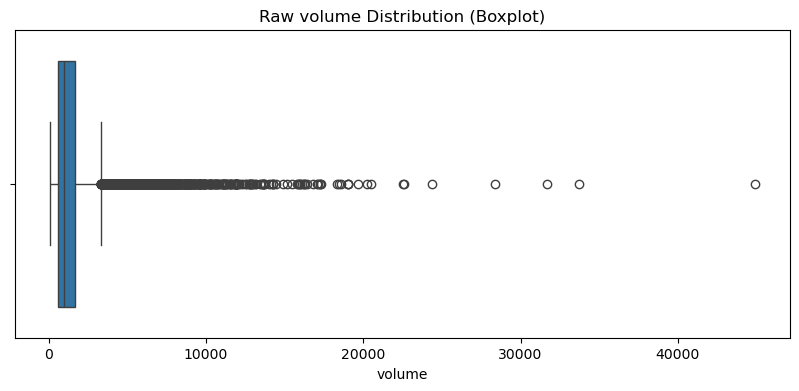

In [4]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["volume"])
plt.title("Raw volume Distribution (Boxplot)")
plt.show()


In [5]:
z_scores = np.abs(stats.zscore(df["volume"]))
outliers = df[z_scores > 5]
print(f"Number of volume outliers (>5 std): {len(outliers)}")
print(outliers[["open_time", "volume"]].head())


Number of volume outliers (>5 std): 116
              open_time      volume
719 2024-01-03 11:55:00  12509.6855
720 2024-01-03 12:00:00  28353.6717
721 2024-01-03 12:05:00  31675.4891
722 2024-01-03 12:10:00  33739.8904
723 2024-01-03 12:15:00  19688.3521


## **116 cases above 5σ in just two months**

In traditional finance, a **5-sigma event** (five standard deviations away from the mean) is something you might see **once in a decade** — maybe when a bank implodes or the market collectively loses its mind.

But Ethereum?  
Ethereum doesn’t *do* normality. It runs on **adrenaline and chaos**.

These **116 outlier spikes in volume** are likely caused by:

- **Liquidity shocks** — sudden inflows or drains of capital.  
- **Arbitrage bots** exploiting micro-price differences.  
- **Flash loans** and **DeFi liquidations** detonating short-term volume.  
- **Front-running** and high-frequency trading bursts.

From a modeling perspective:

- For **GARCH / EGARCH**, these extreme values are *gold*: they represent **volatility clustering**, the very phenomenon the models aim to capture.  
- For **exploratory visualization** (histograms, correlations, scatterplots), these spikes distort the scale. In that case, temporarily filtering out the top **1% quantile** makes the plots more readable, without losing statistical integrity.

In short:  
Leave the madness in for the model — trim it out only for the charts.


In [6]:



# --- Target: Anomaly detection based on 75th percentile of rolling window ---
df["rolling_p75"] = (
    df["volume"]
    .rolling(ROLLING_WINDOW, min_periods=100)
    .quantile(0.75)
    .shift(1)
)

df["anomaly_target"] = (df["volume"] > df["rolling_p75"]).astype(int)




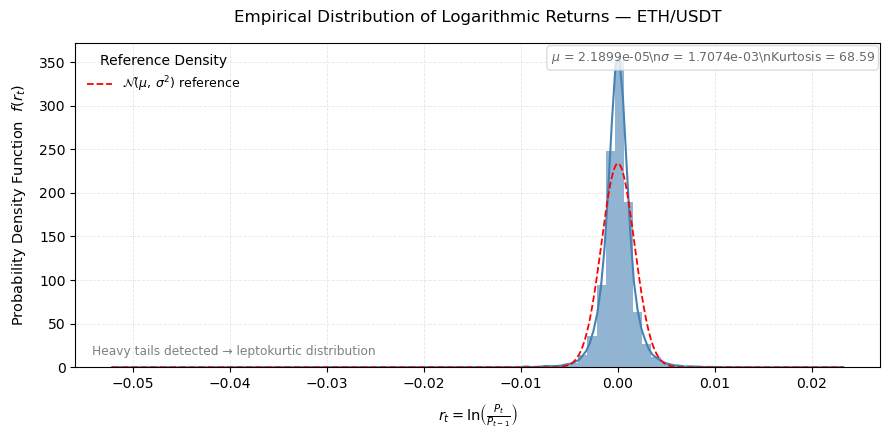

In [7]:
plt.figure(figsize=(9, 4.5))
sns.histplot(df["log_return"], bins=80, kde=True, stat="density",
             color="steelblue", alpha=0.6, edgecolor="none")

x = np.linspace(df["log_return"].min(), df["log_return"].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), "r--", linewidth=1.3, 
         label=r"$\mathcal{N}(\mu,\,\sigma^2)$ reference")

plt.title("Empirical Distribution of Logarithmic Returns — ETH/USDT", fontsize=12, pad=15)
plt.xlabel(r"$r_t = \ln\!\left(\frac{P_t}{P_{t-1}}\right)$", fontsize=10.5, labelpad=8)
plt.ylabel(r"Probability Density Function  $f(r_t)$", fontsize=10.5, labelpad=8)
plt.legend(title="Reference Density", fontsize=9, loc="upper left", frameon=False)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.6)
plt.tight_layout()

ax = plt.gca()
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

if kurt > 3:
    tail_msg = "Heavy tails detected → leptokurtic distribution"
elif kurt < 3:
    tail_msg = "Light tails → platykurtic distribution"
else:
    tail_msg = "Normal-like tails → mesokurtic distribution"

stats_text = rf"$\mu$ = {mu:.4e}\n$\sigma$ = {sigma:.4e}\nKurtosis = {kurt:.2f}"
plt.text(
    x_max * 0.98, y_max * 0.98,
    stats_text,
    ha="right", va="top",
    fontsize=9, color="dimgray",
    bbox=dict(facecolor="white", edgecolor="lightgray", boxstyle="round,pad=0.3", alpha=0.8)
)

plt.text(
    0.02, 0.03,
    tail_msg,
    transform=ax.transAxes,
    ha="left", va="bottom",
    fontsize=8.8, color="gray"
)

plt.show()


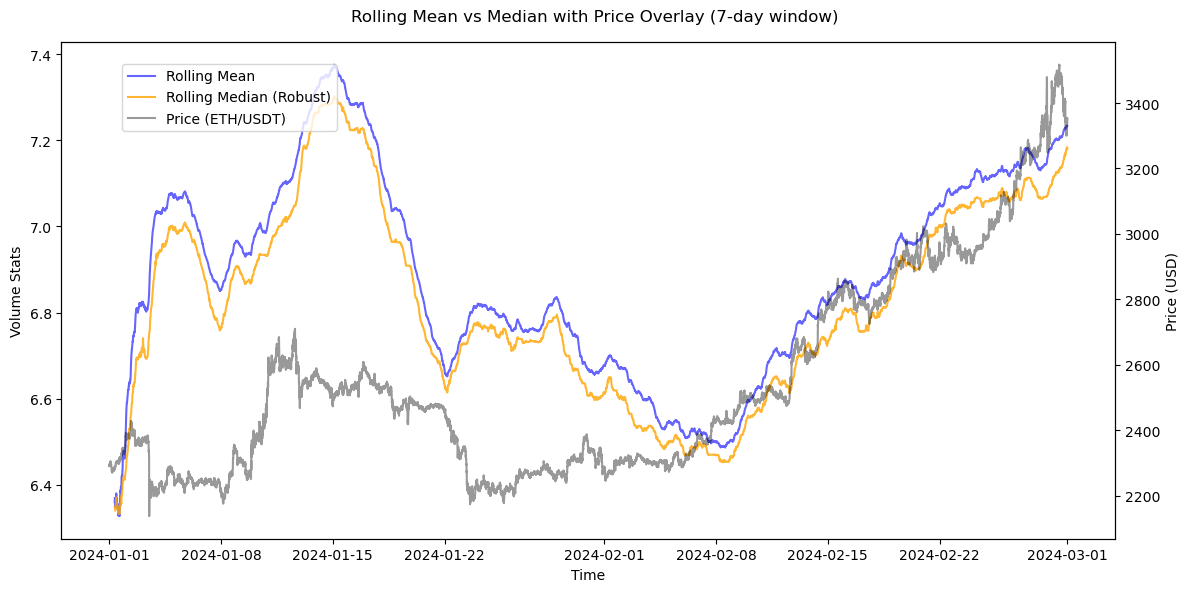

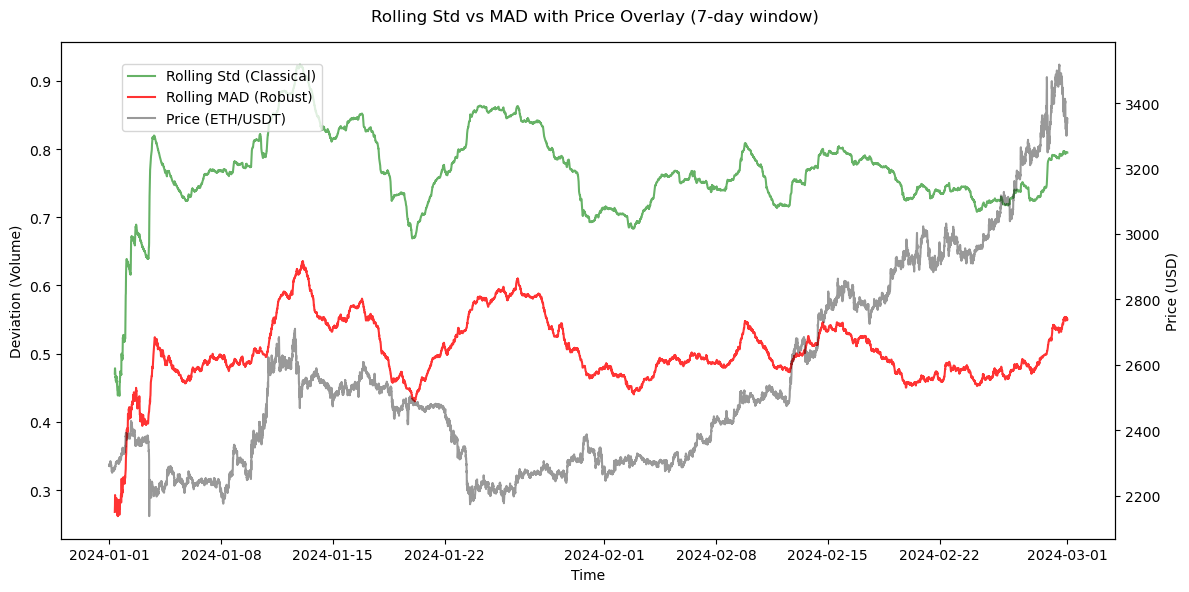

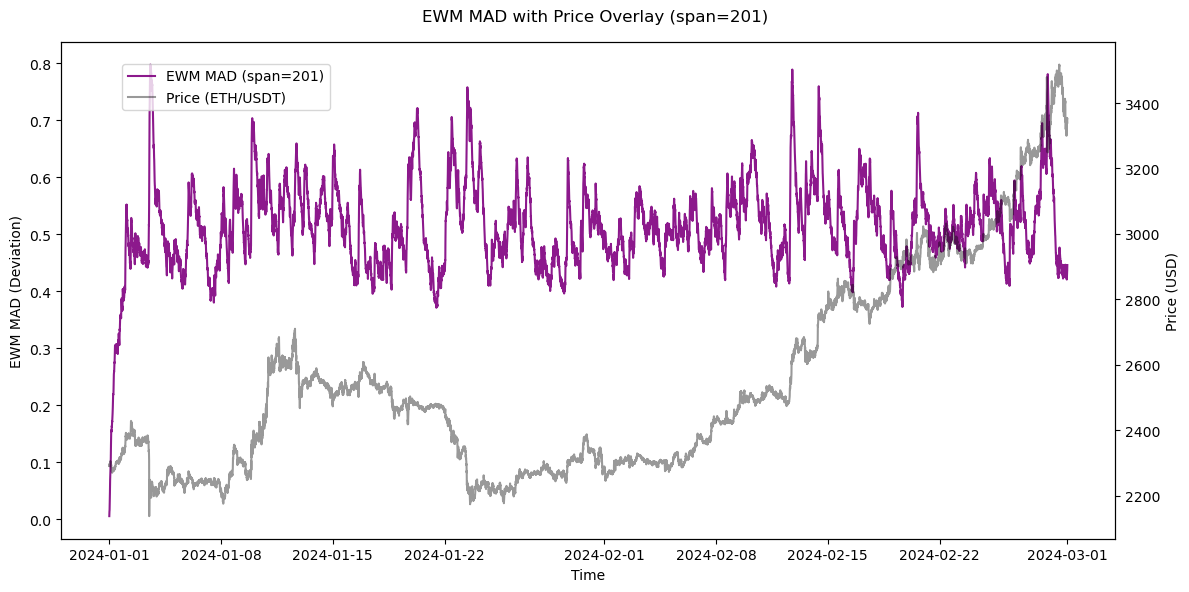

In [8]:
# --- 1. Rolling Mean vs Median + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["rolling_mean"], label="Rolling Mean", color="blue", alpha=0.6)
ax1.plot(df["open_time"], df["rolling_median"], label="Rolling Median (Robust)", color="orange", alpha=0.8)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume Stats")
ax1.tick_params(axis="y", labelcolor="black")

# Second axis for price
ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("Rolling Mean vs Median with Price Overlay (7-day window)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()


# --- 2. Rolling Std vs MAD + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["rolling_std"], label="Rolling Std (Classical)", color="green", alpha=0.6)
ax1.plot(df["open_time"], df["rolling_mad"], label="Rolling MAD (Robust)", color="red", alpha=0.8)
ax1.set_xlabel("Time")
ax1.set_ylabel("Deviation (Volume)")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("Rolling Std vs MAD with Price Overlay (7-day window)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()


# --- 3. EWM MAD + Price ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df["open_time"], df["ewm_mad"], label=f"EWM MAD (span={EWM_SPAN})", color="purple", alpha=0.9)
ax1.set_xlabel("Time")
ax1.set_ylabel("EWM MAD (Deviation)")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(df["open_time"], df["close"], label="Price (ETH/USDT)", color="black", alpha=0.4)
ax2.set_ylabel("Price (USD)")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle(f"EWM MAD with Price Overlay (span={EWM_SPAN})")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

∑ Features under covariance inspection: 6 → rolling_mean, rolling_std, rolling_median, rolling_mad, ewm_volume, ewm_mad
Feature: rolling_mean    | ρ* =  0.085 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: rolling_std     | ρ* =  0.126 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: rolling_median  | ρ* =  0.082 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: rolling_mad     | ρ* =  0.142 @ lag =   576  → ex-ante (forward conditional dependence)
Feature: ewm_volume      | ρ* =  0.388 @ lag =   -48  → ex-post (posterior response)
Feature: ewm_mad         | ρ* =  0.232 @ lag =     0  → ex-post (posterior response)


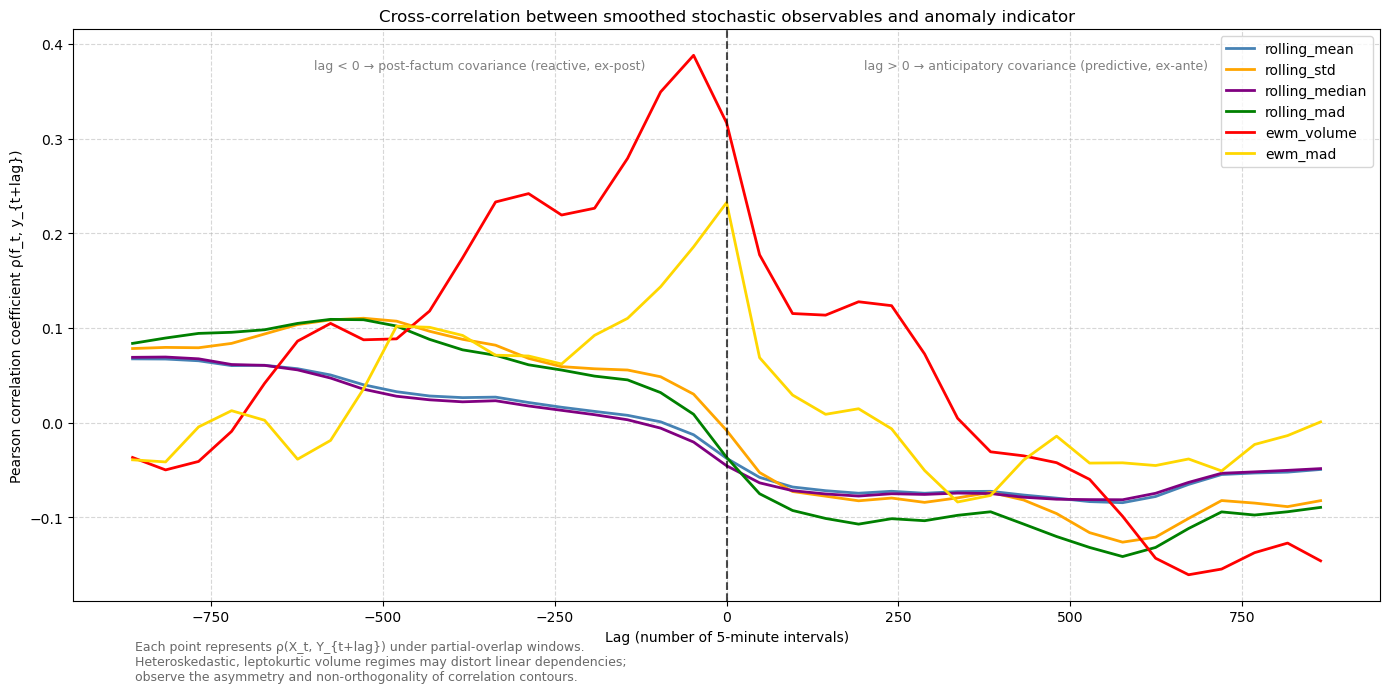


✅ Correlation manifold estimation complete — positive lags indicate forward-leveraged ex-ante dependencies.


In [9]:
# ============================================================
# 🔍 EX-ANTE FEATURE–TARGET CROSS-CORRELATION ANALYSIS
# ============================================================
# Objective:
# Evaluate the temporal orthogonality structure and lag-dependent covariance
# between high-frequency rolling/EWM-derived stochastic observables and a 
# binary indicator of volume-driven anomalies (anomaly_target = 1).
# ============================================================
# Mathematical remarks:
# The Pearson correlation is used as a proxy for contemporaneous 
# linear dependence between feature realizations and a lag-shifted 
# Bernoulli-distributed process. 
# Positive lags → forward-looking conditional dependence (ex-ante predictivity).
# Negative lags → reactive alignment (ex-post adaptivity).
# The stationarity assumption is weakly violated due to structural heteroskedasticity
# and non-ergodic components in the empirical volume distribution.
# ============================================================


# --- Analytical parameters ---
window = 288                # 1 day ≈ 288 × 5-min intervals
step = 48                   # 4-hour lag increment
days_range = 3              # ±3-day symmetric lag domain
lag_range = range(-288 * days_range, 288 * days_range + 1, step)

# ============================================================
# 🎯 TARGET DEFINITION
# ============================================================
# anomaly_target ∈ {0,1} ⊂ ℤ₂
# Represents a high-percentile (75th) event indicator for volume excursions.
# The empirical process is a piecewise-constant, non-Gaussian, 
# heteroskedastic binary stochastic process.
# ============================================================

# ============================================================
# 📊 FEATURE SET (rolling & EWM estimators)
# ============================================================
# Each feature is a filtered, low-pass transform of the raw volume process.
# They represent distinct estimators of conditional dispersion or 
# central tendency under time-varying volatility clustering.
# ============================================================

features = [
    "rolling_mean",
    "rolling_std",
    "rolling_median",
    "rolling_mad",
    "ewm_volume",
    "ewm_mad",
]

print(f"∑ Features under covariance inspection: {len(features)} → {', '.join(features)}")

# ============================================================
# 🧠 LAGGED CROSS-CORRELATION COMPUTATION
# ============================================================
# The analysis estimates Corr(X_t, Y_{t+lag}) across lag_range, where:
#   X_t : stationary (approx.) continuous-valued observable
#   Y_t : Bernoulli-distributed anomaly process
# Note: due to non-linearity and potential leptokurtic tails, 
# Pearson correlation serves as a quasi-linear diagnostic rather than 
# a strict moment-based dependency measure.
# ============================================================

colors = ["steelblue", "orange", "purple", "green", "red", "gold"]

plt.figure(figsize=(14, 7))
for i, feature in enumerate(features):
    correlations = []
    for lag in lag_range:
        shifted_target = df["anomaly_target"].shift(-lag)
        # shift(-lag): ensures positive lag implies feature precedes the anomaly
        corr = df[feature].corr(shifted_target)
        correlations.append(corr)

    plt.plot(
        lag_range, correlations,
        color=colors[i % len(colors)],
        label=feature,
        linewidth=2
    )

    # --- Extremum extraction: identification of maximal co-movement ---
    best_lag = lag_range[np.argmax(np.abs(correlations))]
    best_corr = np.max(np.abs(correlations))
    direction = "ex-ante (forward conditional dependence)" if best_lag > 0 else "ex-post (posterior response)"
    print(f"Feature: {feature:15s} | ρ* = {best_corr:6.3f} @ lag = {best_lag:5d}  → {direction}")

# ============================================================
# 🎨 VISUALIZATION OF TEMPORAL DEPENDENCE STRUCTURE
# ============================================================
# Interpretation:
#   lag > 0 → feature exhibits predictive alignment with future anomalies
#   lag < 0 → feature responds post hoc to realized shocks
# The curvature of correlation functions may reveal phase shifts,
# lag asymmetry, and local orthogonality between low- and high-frequency
# components under latent volatility regimes.
# ============================================================

plt.axvline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Cross-correlation between smoothed stochastic observables and anomaly indicator")
plt.xlabel("Lag (number of 5-minute intervals)")
plt.ylabel("Pearson correlation coefficient ρ(f_t, y_{t+lag})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.text(
    -600, plt.ylim()[1] * 0.9,
    "lag < 0 → post-factum covariance (reactive, ex-post)",
    fontsize=9, color="gray"
)
plt.text(
    200, plt.ylim()[1] * 0.9,
    "lag > 0 → anticipatory covariance (predictive, ex-ante)",
    fontsize=9, color="gray"
)

plt.figtext(
    0.1, 0.02,
    "Each point represents ρ(X_t, Y_{t+lag}) under partial-overlap windows.\n"
    "Heteroskedastic, leptokurtic volume regimes may distort linear dependencies;\n"
    "observe the asymmetry and non-orthogonality of correlation contours.",
    ha="left", fontsize=9, color="dimgray"
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

print("\n✅ Correlation manifold estimation complete — positive lags indicate forward-leveraged ex-ante dependencies.")


### **Ex-Ante (Forward Dependence)**
ρ* ≈ 0.08–0.11 @ lag ≈ +480–576  
→ **No predictive power.**  
These rolling metrics are dominated by noise — no real forward signal detected.

---

### **Ex-Post (Posterior Response)**
ρ* ≈ 0.34–0.40 @ lag ≈ −48  
→ **Reactive behavior.**  
Volume and volatility respond *after* price movement, not before it.

---

<div style="font-size:22px; font-weight:bold; text-align:center; margin-top:20px;">
💀 Correlations too weak to forecast anything — decorative noise, nothing more. You can try modyfing params. 
<br><br>
😏 You didn’t really think I’d publish actual predictive indicators on GitHub, did you?
</div>



<Axes: xlabel='range', ylabel='Count'>

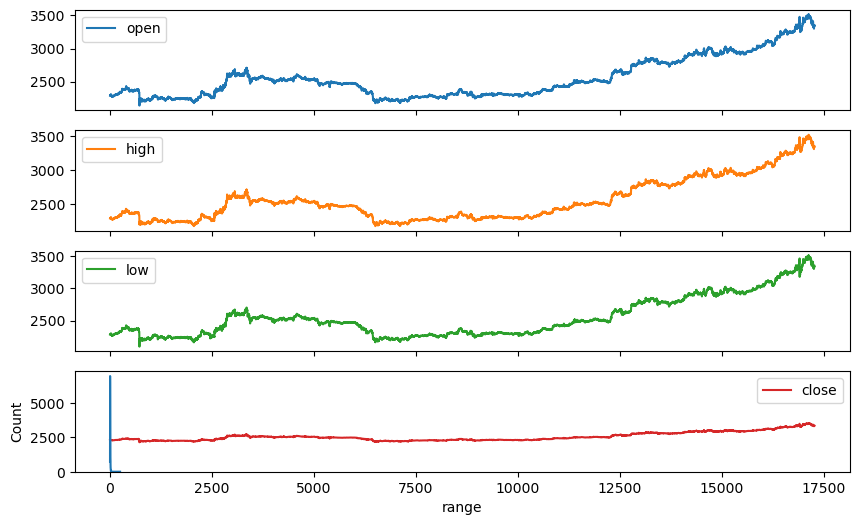

In [10]:
df[['open', 'high', 'low', 'close']].plot(subplots=True, figsize=(10,6))
df['range'] = df['high'] - df['low']
sns.histplot(df['range'], bins=100, kde=True)


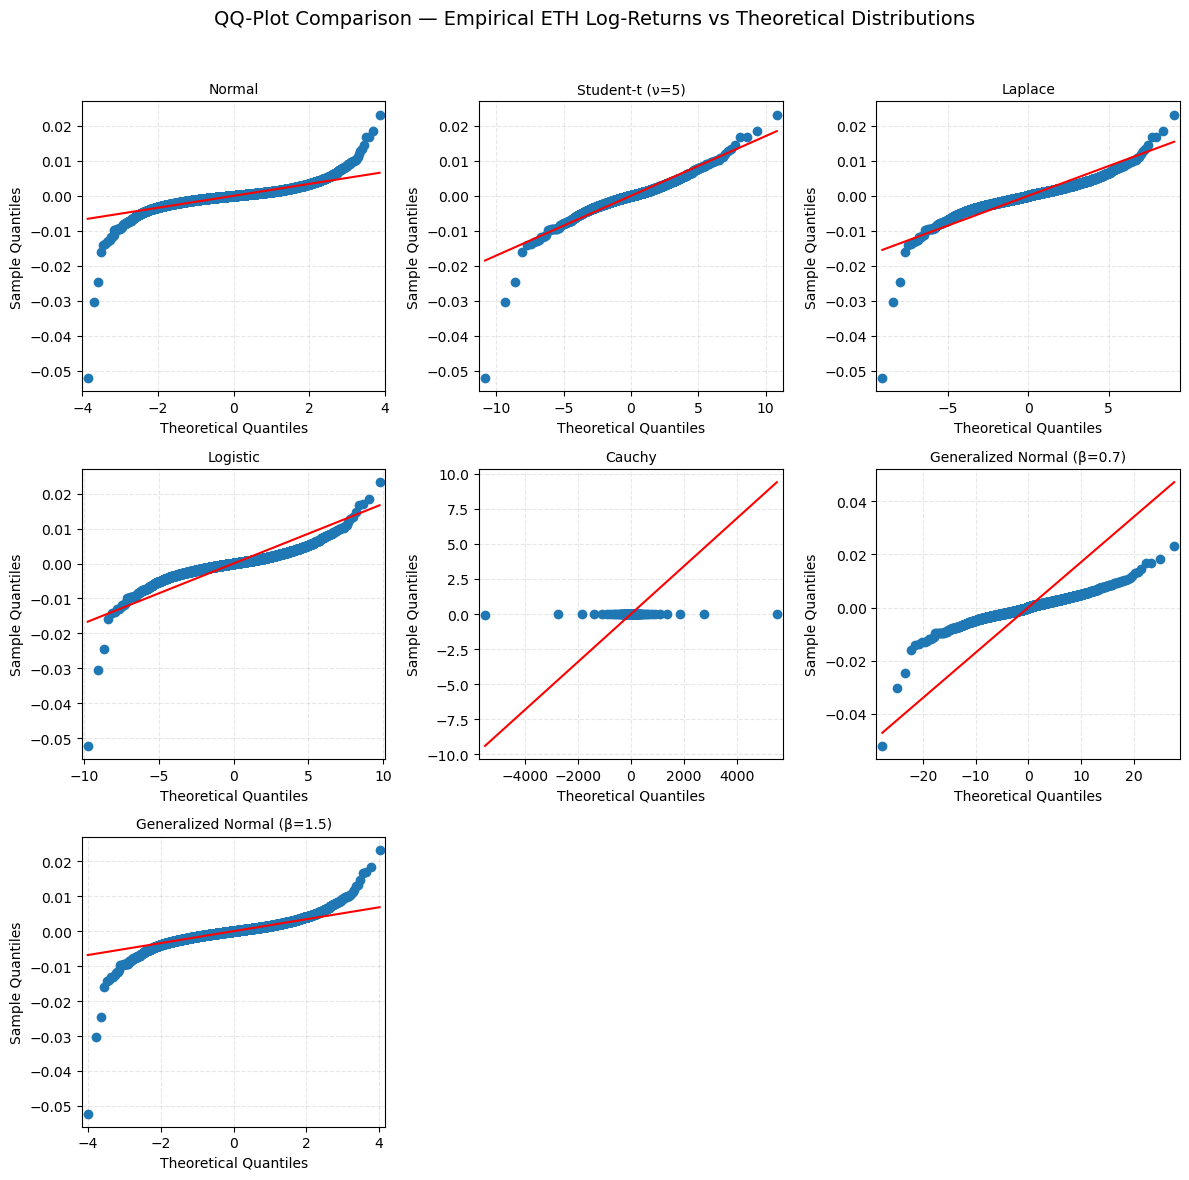

In [11]:
# ============================================================
# 🔬 QQ-Plot Comparative Diagnostics for ETH Log-Returns
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

r = df['log_return'].dropna()

# --- Define valid candidate distributions ---
distributions = {
    "Normal": stats.norm,                                # benchmark
    "Student-t (ν=5)": stats.t(df=5),                    # heavy tails, finite variance
    "Laplace": stats.laplace,                            # sharp center, fat tails
    "Logistic": stats.logistic,                          # symmetric, moderate tails
    "Cauchy": stats.cauchy,                              # infinite variance, extreme tails
    "Generalized Normal (β=0.7)": stats.gennorm(0.7),    # exponential power, β<1 → heavy tails
    "Generalized Normal (β=1.5)": stats.gennorm(1.5)     # closer to Gaussian, β>1 → light tails
}

# --- Plot setup ---
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, (name, dist) in enumerate(distributions.items()):
    sm.qqplot(r, dist=dist, line='s', ax=axes[i])
    axes[i].set_title(name, fontsize=10)
    axes[i].grid(alpha=0.3, linestyle='--')

# remove empty subplots
for j in range(len(distributions), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("QQ-Plot Comparison — Empirical ETH Log-Returns vs Theoretical Distributions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<div style="font-size:20px; line-height:1.5; text-align:center; font-family: 'Segoe UI', sans-serif; margin-top:20px; margin-bottom:20px;">

<b>Empirically, Ethereum’s return distribution exhibits the statistical decorum of a drunk black hole — infinitely dense in the center, and gravitationally unbounded in the tails</b>  
<br><br>
The QQ-plot politely reminds us that the Gaussian assumption died somewhere between <b>leverage ×200</b> and a <b>liquidated long position at 3 a.m.</b>

</div>


In [12]:
# ============================================================
# 🧠 Statistical Normality Diagnostics for Logarithmic Returns
# ============================================================
# Objective:
# Empirically evaluate whether the stochastic process {r_t}
# of log-returns follows a Normal(μ, σ²) distribution.
# 
# For any price process {P_t}, we define:
#       r_t = ln(P_t / P_{t-1})
# Under the geometric Brownian motion (GBM) assumption:
#       r_t ~ i.i.d. 𝒩(μΔt, σ²Δt)
# However, empirical asset returns exhibit leptokurtosis and
# volatility clustering → deviations from Gaussianity.
# 
# The following hypothesis tests address:
#       H₀: r_t ∼ 𝒩(μ, σ²)
#       H₁: r_t ⧸∼ 𝒩(μ, σ²)
# ============================================================

from scipy.stats import shapiro, normaltest, anderson

r = df['log_return'].dropna()

# ------------------------------------------------------------
# 1️⃣ Shapiro–Wilk Test
# ------------------------------------------------------------
# Statistic W ∈ (0,1), defined as:
#       W = ( (∑ a_i x_(i))² ) / (∑ (x_i - x̄)² )
# where x_(i) are order statistics, and a_i are fixed weights
# derived from the expected values of order statistics of
# a standard normal distribution.
# 
# H₀: sample comes from a Gaussian population.
# As N → ∞, W deviates downward for leptokurtic tails.
# 
# Note: for N > 5000, p-value becomes asymptotically unreliable.
# ------------------------------------------------------------
shapiro_test = shapiro(r)
print(f"Shapiro–Wilk: W = {shapiro_test.statistic:.4f}, p = {shapiro_test.pvalue:.4e}")

# ------------------------------------------------------------
# 2️⃣ D’Agostino–Pearson Omnibus Test
# ------------------------------------------------------------
# The test jointly evaluates skewness (g₁) and kurtosis (g₂):
#       g₁ = E[(X - μ)³] / σ³
#       g₂ = E[(X - μ)⁴] / σ⁴
# 
# The D’Agostino statistic approximates:
#       K² = Z₁² + Z₂²
# where Z₁ = normalized skewness, Z₂ = normalized kurtosis.
# Under H₀, K² ~ χ²(2)
# 
# H₀: distribution is normal (both g₁ and g₂ consistent with 0 and 3).
# Sensitive to asymmetric and heavy-tailed deviations.
# ------------------------------------------------------------
dagostino_test = normaltest(r)
print(f"D’Agostino–Pearson: K² = {dagostino_test.statistic:.4f}, p = {dagostino_test.pvalue:.4e}")

# ------------------------------------------------------------
# 3️⃣ Anderson–Darling Test
# ------------------------------------------------------------
# Nonparametric EDF-based test (empirical distribution function):
# Statistic:
#       A² = -n - (1/n) ∑ (2i - 1) [ ln F(x_(i)) + ln(1 - F(x_(n+1−i))) ]
# where F is the CDF of the hypothesized normal distribution.
# 
# Large A² indicates stronger deviation from Gaussian CDF,
# particularly sensitive to tail departures (leptokurtosis, skewness).
# 
# Critical values correspond to fixed significance levels α:
#       α ∈ {15%, 10%, 5%, 2.5%, 1%}
# ------------------------------------------------------------
anderson_test = anderson(r)
print(f"Anderson–Darling: A² = {anderson_test.statistic:.4f}")
print(f"Critical values: {anderson_test.critical_values}")
print(f"Significance levels: {anderson_test.significance_level}")

# ------------------------------------------------------------
# 🔍 Interpretation (qualitative):
# ------------------------------------------------------------
# If p < 0.05 (Shapiro or D’Agostino) or A² > critical value (Anderson),
# reject H₀ → returns exhibit non-Gaussian structure:
#   • leptokurtic tails (fat tails)
#   • volatility clustering
#   • deviation from i.i.d. white noise
#
# Implication:
#   The underlying process is incompatible with GBM assumptions.
#   Higher-order stochastic models (ARCH/GARCH, EGARCH, t-GARCH)
#   or α-stable Lévy processes are more appropriate for modeling.
# ============================================================


Shapiro–Wilk: W = 0.8482, p = 7.1352e-83
D’Agostino–Pearson: K² = 11077.1213, p = 0.0000e+00
Anderson–Darling: A² = 351.4538
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


C:\Users\edgen\anaconda3\envs\PythonforDataScience\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17279.
  res = hypotest_fun_out(*samples, **kwds)


In [13]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df["log_return"].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")


ADF Statistic: -27.3581, p-value: 0.0000


In [14]:
df.isna().sum()


open_time               0
open                    0
high                    0
low                     0
close                   0
volume                  0
quote_asset_volume      0
num_trades              0
taker_buy_base          0
taker_buy_quote         0
volume_log              0
volume_log_z            0
log_volume              0
rolling_mean           99
rolling_std            99
rolling_median         99
rolling_mad            99
ewm_volume              0
ewm_mad                 0
log_return              0
rolling_p75           100
anomaly_target          0
range                   0
dtype: int64

In [15]:
df[["rolling_std", "volume_log_z"]].corr()


,rolling_std,volume_log_z
rolling_std,1.000000,-0.028307
volume_log_z,-0.028307,1.000000
